<a href="https://colab.research.google.com/github/safa-abidi/NLP-sentimentAnalysis-AraBert/blob/main/Naive_Bayes_Self_training_Semi_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd

import plotly.express as px

import xml.etree.ElementTree as ET
import pandas as pd
import os

from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [2]:
from typing import Any, Dict, List, Callable, Optional, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import torch

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00


In [4]:

from transformers import BertModel, BertTokenizer
import torch
import transformers

In [5]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Dataset: labelled and unlabled

In [6]:
DATASETS_PATH = '/content/drive/MyDrive/'

%cd /content/drive/MyDrive/datasets

# Labeled Dataset
labeled_dataset_path = 'dataset_arabic_translated/Merged_Labelled_Arabic_fake_news_Dataset.xlsx'
labeled_dataset = pd.read_excel(labeled_dataset_path)
print("Labeled Dataset",labeled_dataset.shape)


# Unlabeled Dataset
unlabeled_dataset_path = 'SemEval2016_arabic/AR_Hotels_Train_SB1.xml'
tree = ET.parse(unlabeled_dataset_path)
root = tree.getroot()

# Extract reviews from XML and add to list of tuples
reviews = []
for review in root.iter('Review'):
    for sentence in review.iter('sentence'):
        text = sentence.find('text').text.strip()
        label = -1
        reviews.append((text, label))

# Create a pandas DataFrame from the list of tuples
unlabeled_dataset = pd.DataFrame(reviews, columns=['Review', 'Class'])
print("Unlabeled Dataset",unlabeled_dataset.shape)

df = pd.concat([labeled_dataset, unlabeled_dataset], axis=0)

# Reset the index of the concatenated DataFrame
df = df.reset_index(drop=True)


/content/drive/.shortcut-targets-by-id/1yQmug2Km3lcyLzCJRQKL27azhrH4dHz5/datasets
Labeled Dataset (1600, 6)
Unlabeled Dataset (4802, 2)


In [7]:
## Encode the dataset labels

df['Label'] = df.apply(lambda x: 0 if x['Class'] == 'خادع' else 1 if x['Class'] == 'صادقة' else -1, axis=1)

In [8]:
# data split
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0)
print('Size of train dataframe: ', df_train.shape[0])
print('Size of test dataframe: ', df_test.shape[0])

Size of train dataframe:  5121
Size of test dataframe:  1281


# BERT transformer

In [9]:


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        tokenizer,
        model,
        max_length: int = 60,
        embedding_func: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_length,truncation=True
        )["input_ids"]
        
        # padding
        padded_text = tokenized_text + [0]*(self.max_length-len(tokenized_text))

        # Create an attention mask telling BERT to use all words and ignore padded values
        attention_mask = np.where(np.array(padded_text) != 0, 1, 0)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(padded_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.Tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self
    
def calculate_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    average: Optional[str] = None,
    return_df: bool = True,
) -> Union[Dict[str, float], pd.DataFrame]:
    """Computes f1, precision, recall, precision, kappa, accuracy, and support

    Args:
        y_true: The true labels
        y_pred: The predicted labels
        average: How to average multiclass results

    Returns:
        Either a dataframe of the performance metrics or a single dictionary
    """
    labels = unique_labels(y_true, y_pred)
    # get results
    precision, recall, f_score, support = sk_metrics.precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=average
    )

    kappa = sk_metrics.cohen_kappa_score(y_true, y_pred, labels=labels)
    accuracy = sk_metrics.accuracy_score(y_true, y_pred)

    # create a pandas DataFrame
    if return_df:
        results = pd.DataFrame(
            {
                "class": labels,
                "f_score": f_score,
                "precision": precision,
                "recall": recall,
                "support": support,
                "kappa": kappa,
                "accuracy": accuracy,
            }
        )
    else:
        results = {
            "f1": f_score,
            "precision": precision,
            "recall": recall,
            "kappa": kappa,
            "accuracy": accuracy,
        }

    return results

## AraBERT embedding

In [10]:
tokenizer = BertTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
tokenized_dict = tokenizer.encode_plus(
    df_train["Review"].tolist(),
    add_special_tokens=True,
    max_length=512,  # Set maximum sequence length here
    truncation=True,
    )

bert_model = BertModel.from_pretrained("aubmindlab/bert-base-arabertv2")
tokenized_text = torch.tensor(tokenized_dict["input_ids"])
with torch.no_grad():
  embeddings = bert_model(torch.tensor(tokenized_text.unsqueeze(0)))

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-10-37db532cadec>:12: UserWarning: To copy construct from a tensor, it is recommended to use sou

# Model classifier

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score

In [12]:
X_train=df_train['Review']
y_train=df_train['Label'].values

X_test=df_test['Review']
y_test=df_test['Label'].values

def model_generation(threshold):

  bert_transformer = BertTransformer(tokenizer, bert_model)
  ## Naive Bayes model
  nb_model = GaussianNB()
  # Self training classifier
  classifier = SelfTrainingClassifier(base_estimator=nb_model,
                                      threshold=threshold,
                                      criterion='threshold',
                                      max_iter=100, 
                                      verbose=True,)
  model = Pipeline([
       ("vectorizer", bert_transformer),
       ("classifier", classifier),
       ])
  return model

#########################################

In [13]:
def show_report(clf_ST):
  print('')
  print('---------- Self Training Model - Summary ----------')

  print('Classes: ', clf_ST.classes_)

  print('---------- Self Training Model - Evaluation on Test Data ----------')
  y_pred = clf_ST.predict(X_test)
  accuracy_score_ST = accuracy_score(y_test, y_pred)
  print('Accuracy Score: ', accuracy_score_ST)

  # Look at classification report to evaluate the model
  report = classification_report(y_test, y_pred ,labels=[0, 1])
  print(report)
  return report, accuracy_score_ST

In [14]:
thresholds = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
clfs = []
reports = []
accuracies = []
for i, threshold  in enumerate(thresholds):
  print('---------- ', threshold,' ----------')
  clf_ST = model_generation(threshold).fit(X_train, y_train)
  clfs.append(clf_ST)
  report, accuracy = show_report(clf_ST)
  reports.append(report)
  accuracies.append(accuracy)


----------  0.6  ----------
End of iteration 1, added 3818 new labels.
End of iteration 2, added 15 new labels.

---------- Self Training Model - Summary ----------
Classes:  [0 1]
---------- Self Training Model - Evaluation on Test Data ----------
Accuracy Score:  0.12724434035909446
              precision    recall  f1-score   support

           0       0.31      0.76      0.44       167
           1       0.04      0.25      0.07       145

   micro avg       0.13      0.52      0.20       312
   macro avg       0.17      0.50      0.25       312
weighted avg       0.18      0.52      0.27       312

----------  0.7  ----------
End of iteration 1, added 3806 new labels.
End of iteration 2, added 27 new labels.

---------- Self Training Model - Summary ----------
Classes:  [0 1]
---------- Self Training Model - Evaluation on Test Data ----------
Accuracy Score:  0.12724434035909446
              precision    recall  f1-score   support

           0       0.31      0.76      0.44   

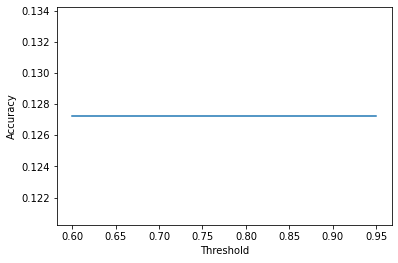

In [19]:
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()